Dimensions: 150 x 4
labels: [0 1 2]
Class distribution: [50 50 50]
Computing my t-SNE embedding


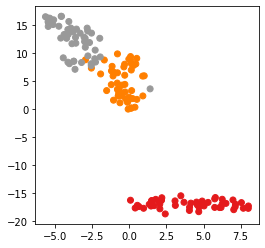

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: modified by Thierry Paquet for teaching purpose
         Master Science et Ingénierie des Données
         University of Rouen Normandie
         2021
from Laurens van der Maaten https://lvdmaaten.github.io/tsne/
"""

import numpy as np
import time

import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn import datasets
from sklearn.manifold import TSNE

def Hsigma(Dij, sigma_i):
    Numij = np.exp(-Dij / sigma_i)
    Denij = sum(Numij)  # dénominateur
    Pij = Numij / Denij
    
    Hi = np.log(Denij) + np.sum(Dij * Pij)/ (sigma_i * Denij)

    return (Hi, Pij)

def Dist2Proba(Dij2, tol, PP):
    '''
    Dij2: les distances euclidiennes point à point au carré
    tol : tolérance sur l'entropie de la distribution Gaussienne recherché
    PP  : perplexité de la distribution Gaussienne du voisinage
    '''
    (n, d) = Dij2.shape
    Pij = np.zeros((n, n))      # le tableau des probas initialisé à 0
    sigma_i = np.ones((n, 1))   # le vecteurs des variances intialisé à 1
    H = np.log(PP)              # l'entropie pour le perplexité recherchée
    #Dij2 = np.square(Dij)       # les normes au carré

    # on calcule les Pij pour chaque point i
    for i in range(n):
        # on ajuste progessivement la valeur de sigma_i jusqu'à atteinde l'entropie souhaitée   
        # on extrait les n-1 distances aux voisins
        Di = Dij2[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        
        # on calcule l'entropie et la distribution des probas pour la valeur courante de sigma_i
        (Hi, Pi) = Hsigma(Di, sigma_i[i])
        
        # Boucle principale d'ajustement de sigma_i par dichotomie
        # tant qu'on n'est pas dans la tolérance de l'entropie souhaitée
        # et qu'on a fait moins de 50 itérations
        Hdiff = Hi - H
        tries = 0
        
        sigmamin = -np.inf
        sigmamax = np.inf
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0: # l'entropie est trop forte par rapport à la cible
                          # il faut réduire sigma (diviser par 2) 
                          # sans qu'il devienne inférieur à la valeur min actuelle
                sigmamax = sigma_i[i].copy()
                if sigmamin == np.inf or sigmamin == -np.inf:
                    sigma_i[i] = sigma_i[i] / 2.
                else:
                    sigma_i[i] = (sigma_i[i] + sigmamin) / 2.
                    
            else:         # l'entropie est trop faible il faut augmenter sigma (multiplier par 2)
                          # sans qu'il devienne supérieur à la valeur max actuelle
                sigmamin = sigma_i[i].copy()
                if sigmamax == np.inf or sigmamax == -np.inf:
                    sigma_i[i] = sigma_i[i] * 2.
                else:
                    sigma_i[i] = (sigma_i[i] + sigmamax) / 2.
                
            # Puis on recalcule l'entropie et les proba des voisins
            (Hi, Pi) = Hsigma(Di, sigma_i[i])
            Hdiff = Hi - H
            tries += 1
        # fin de la boucle while
                    
        #on mémorise la distribution des probas des voisins dans la matrice 
        Pij[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = Pi
        #print("Valeur moyenne des sigma_i: %f" % np.mean(np.sqrt(sigma_i)))
    return Pij

def my_tSNE(n_dims,X,PP,LR,init_momentum,final_momentum,max_iter):
    '''
    n_dims         : dimension de l'espace d'arrivée, en général 2
    X              : tableau des points de mesures rangées ligne à ligne
    PP             : perplexité pour la modélisation Gaussienne du voisinage
    LR             : learning rate pour la descente de gradient
    init_momentum  : pour la descente de gradient
    final_momentum : 
    max_iter       : nombre maximal d'itérations
    '''
    (n, d) = X.shape
    # Etape 1 : calcul des distances euclidiennes paire à paire    

    sum_X = np.sum(np.square(X), 1)
    DX = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

    # Etape 2 : calcul des pij d'être voisin de Xi pour tous les i
    Pij = Dist2Proba(DX, 1e-5, PP)

    # Etape 3: symétrise les probabilités
    Pij = (Pij + np.transpose(Pij)) / (2*n-2) #np.sum(Pij)
    Pij = Pij * 12.	# early exaggeration
    Pij = np.maximum(Pij, 1e-12)        # seuillage pour éviter pb 
    
    # Etape 4 : intitialisation aléatoire des points projetés selon une Gaussienne isotrope
    Y = np.random.randn(n, n_dims)
    
    # initialisation 
    dY = np.zeros((n, n_dims))    # à 0 des dérivées
    iY = np.zeros((n, n_dims))    # à 0 de l'accroissement à chaque itération
    #gains = np.ones((n, n_dims))  # à 1 du terme
    
    # Etape 5 : Boucle principale de descente du gradient
    for iter in range(max_iter):
        # Etape 5.1 : calcul des distances euclidiennes paire à paire dans l'espace projeté  
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.  # annule les termes sur la diagonale
        Qij = num / np.sum(num)
        Qij = np.maximum(Qij, 1e-12)
        
        # Etape 5.2 : Calcul du gradient
        PQij = Pij - Qij
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQij[:, i] * num[:, i], (n_dims, 1)).T * (Y[i, :] - Y), 0)

        # Etape 5.3 : Mise à jour des points projetés
        if iter < 20:
            momentum = init_momentum
        else:
            momentum = final_momentum
    
        iY = -LR * dY + momentum*iY
        Y = Y + iY
        # on centre les données projetées
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))
        
        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(Pij * np.log(Pij / Qij))
            #print("Iteration %d: KL divergence is %f" % (iter + 1, C))
            
        # après 100 itérations on arrête l'amplification des probas
        if iter == 100:
            Pij = Pij / 12.
            
    return Y
        
IRIS = True
MNIST = False


if IRIS:
    titre ='t-SNE - IRIS'
    iris = datasets.load_iris()
    X = iris.data  
    y = iris.target
    
    N = X.shape[0]
    n_components = 2
    n_neighbors = 4
elif MNIST:
    titre = 't-SNE - MNIST'
    digits = datasets.load_digits(n_class=6)
    X = digits.data
    y = digits.target
    
    N = X.shape[0]
    n_components = 2
    n_neighbors = 4

print('Dimensions: %s x %s' % (X.shape[0], X.shape[1]))
print('labels: %s' % np.unique(y))
print('Class distribution: %s' % np.bincount(y))


##----------------------------------------------------------------------
## Appel à my_tSNE
#----------------------------------------------------------------------
print("Computing my t-SNE embedding")
PP = 10
LR = 200
init_momentum = 0.2
final_momentum = 0.8 
max_iter = 1000
my_Y_tsne = my_tSNE(n_components,X,PP,LR,init_momentum,final_momentum,max_iter)
fig, ax = plt.subplots(figsize=(4,4))
scatter = ax.scatter(my_Y_tsne[:,0], my_Y_tsne[:,1], c=y[0:N], cmap=plt.cm.Set1)
#legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title=titre)
#ax.add_artist(legend1) 

In [3]:
##----------------------------------------------------------------------
## Appel à SCIKIT Learn
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
#print("Computing scikit learn t-SNE embedding")


Y_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(X)
fig, ax = plt.subplots(figsize=(4,4))
scatter = ax.scatter(Y_tsne[:,0], Y_tsne[:,1], c=y[0:N], cmap=plt.cm.Set1)
#legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title=titre)
#ax.add_artist(legend1) 